In [ ]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# Read, normalize, and invert the image pixels
img = cv2.imread('dziady2.jpg', cv2.IMREAD_GRAYSCALE)

# Binarizacja z progiem
_, binary_image = cv2.threshold(img, 220, 1, cv2.THRESH_BINARY)
binary_image = 1 - binary_image


n_pixels = binary_image.shape[0] * binary_image.shape[1]
print("Number of pixels:", n_pixels)
print("Image shape:",binary_image.shape)
print("Unique values:",np.unique(binary_image))

Number of pixels: 2882856
Image shape: (1356, 2126)
Unique values: [0 1]


In [ ]:
n_white_pixels = np.count_nonzero(binary_image)
n_black_pixels = n_pixels - n_white_pixels
print("# white pixels:", n_white_pixels, "# black pixels:", n_black_pixels, "Image shape:",img.shape)

# white pixels: 277164 # black pixels: 2605692 Image shape: (1356, 2126)


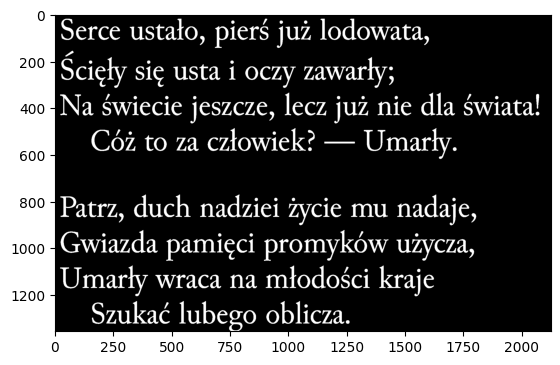

In [ ]:
# Show binary image
plt.imshow(binary_image, cmap="gray")
plt.show()

In [ ]:
horizontal = np.copy(binary_image)
# Define and create a horizontal structuring element to find words
horizontal_size = 1200
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))

In [ ]:
# Apply morphology operations. Dilation and erosion
horizontal = cv2.dilate(horizontal, horizontalStructure)
horizontal = cv2.erode(horizontal, horizontalStructure)

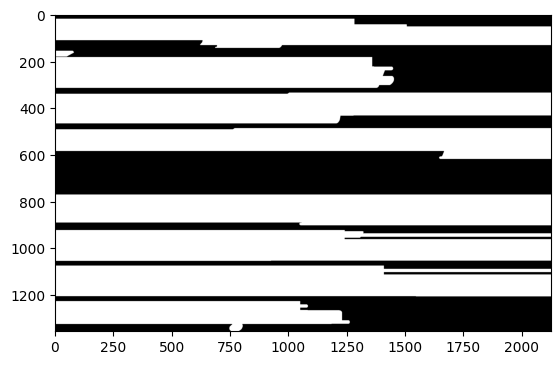

In [ ]:
# show intermediate results
plt.imshow(horizontal, cmap="gray")
plt.show()

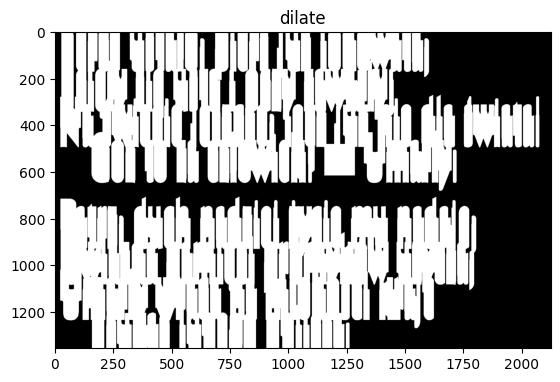

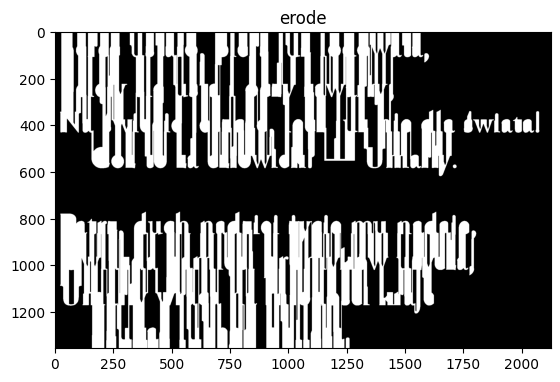

In [ ]:
# Create structure element for extracting vertical lines (within words) through morphology operations
vertical = np.copy(binary_image)
verticalsize = 128
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations, dilation + erosion
vertical = cv2.dilate(vertical, verticalStructure)

plt.figure()
plt.title("dilate")
plt.imshow(vertical, cmap="gray")

vertical = cv2.erode(vertical, verticalStructure)
plt.figure()
plt.title("erode")
plt.imshow(vertical, cmap="gray")

In [ ]:
# Merge and Close the final representation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (28, 12))
merge = vertical * horizontal
closing = cv2.morphologyEx(merge, cv2.MORPH_CLOSE, kernel)

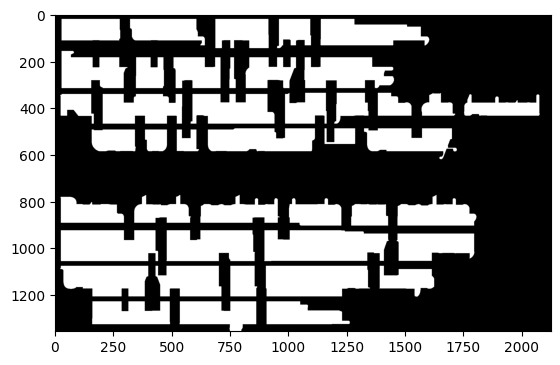

In [ ]:
plt.imshow(closing, cmap="gray")
plt.show()

In [ ]:
# Find connected components
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing)
print("# of boxes (word candidates):",nlabels)

# of boxes (word candidates): 45


In [ ]:
def count_transitions(img):
  assert len(np.unique(img)) <= 2, "Image is not binary"
  black_pixel = 0

  # template: white --> black
  template = [1,0]

  row_length = img.shape[1]
  if row_length % 2 != 0:
    row_length = row_length-1

  transitions = 0
  for row in img:
    for i in range(row_length):
      if np.all(template == row[i:i+2]):
        transitions+=1
  return transitions

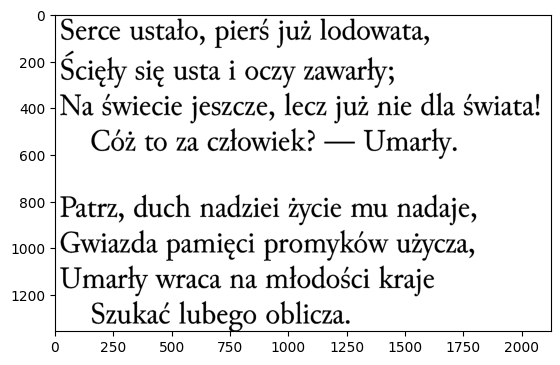

In [ ]:
# reinvert pixels to compute features
img = cv2.bitwise_not(binary_image)-254
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
# transform image to rgb to draw bbxes
rgb = np.zeros((img.shape[0], img.shape[1], 3))
rgb[:,:,0] = img
rgb[:,:,1] = img
rgb[:,:,2] = img

In [ ]:
n_words = 0
for box in stats:

    l = box[0]
    t = box[1]
    r = box[0] + box[2]
    b = box[1] + box[3]

    # get the bbox
    img_patch = closing[t:b,l:r]
    real_patch = img[t:b,l:r]
    n_pixels_box = img_patch.shape[0] * img_patch.shape[1]

    if (n_pixels_box / n_pixels) > 0.9:
      continue
    # 0 --> black pixel
    # 1 --> white pixel

    n_white_pixels = np.count_nonzero(real_patch)
    n_black_pixels = n_pixels_box - n_white_pixels
    print("# white pixels:", n_white_pixels, "# black pixels:", n_black_pixels, "Image shape:",img_patch.shape)

    ht = count_transitions(real_patch)
    vt = count_transitions(real_patch.T)

    pixel_ratio = n_black_pixels / n_pixels_box
    transition_ratio = (ht+vt)/n_pixels_box

    # heiristics for classifying blobs as text or non text
    if (pixel_ratio >= 0.075 and pixel_ratio <= 0.8) and transition_ratio >= 0.01:
      # print("ht:",ht,"vt:",vt,"pixel_ratio:",pixel_ratio,"transition_ratio:",transition_ratio)
      # print("n_pixels", n_pixels_box)
      n_words += 1
      cv2.rectangle(rgb,(l,t),(r,b),(0,255,0),2)


# white pixels: 8 # black pixels: 6 Image shape: (7, 2)
# white pixels: 17323 # black pixels: 5769 Image shape: (92, 251)
# white pixels: 28821 # black pixels: 7339 Image shape: (113, 320)
# white pixels: 22578 # black pixels: 5922 Image shape: (125, 228)
# white pixels: 14437 # black pixels: 3813 Image shape: (125, 146)
# white pixels: 41504 # black pixels: 11041 Image shape: (113, 465)
# white pixels: 37029 # black pixels: 7809 Image shape: (159, 282)
# white pixels: 12610 # black pixels: 3230 Image shape: (132, 120)
# white pixels: 21969 # black pixels: 4563 Image shape: (132, 201)
# white pixels: 2687 # black pixels: 877 Image shape: (132, 27)
# white pixels: 23961 # black pixels: 4551 Image shape: (132, 216)
# white pixels: 41322 # black pixels: 9366 Image shape: (132, 384)
# white pixels: 19294 # black pixels: 4202 Image shape: (132, 178)
# white pixels: 15456 # black pixels: 3816 Image shape: (132, 146)
# white pixels: 10710 # black pixels: 3402 Image shape: (98, 144)
# white pi

In [ ]:
print("Number of words:",n_words)

Number of words: 43


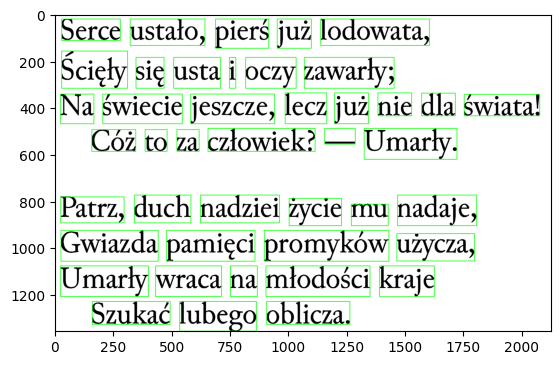

In [ ]:
# This image has to be rbg to print colored boxes
plt.imshow(rgb)
plt.show()